In [ ]:
!cat Dataset* > Dataset.zip

In [ ]:
!unzip Dataset.zip

Kết quả truyền trực tuyến bị cắt bớt đến 5000 dòng cuối.
  inflating: Dataset/eosinophil/EO_581610.jpg  
  inflating: Dataset/eosinophil/EO_810213.jpg  
  inflating: Dataset/eosinophil/EO_801674.jpg  
  inflating: Dataset/eosinophil/EO_761108.jpg  
  inflating: Dataset/eosinophil/EO_106564.jpg  
  inflating: Dataset/eosinophil/EO_327928.jpg  
  inflating: Dataset/eosinophil/EO_119952.jpg  
  inflating: Dataset/eosinophil/EO_376623.jpg  
  inflating: Dataset/eosinophil/EO_769223.jpg  
  inflating: Dataset/eosinophil/EO_67379.jpg  
  inflating: Dataset/eosinophil/EO_330411.jpg  
  inflating: Dataset/eosinophil/EO_233502.jpg  
  inflating: Dataset/eosinophil/EO_874796.jpg  
  inflating: Dataset/eosinophil/EO_769690.jpg  
  inflating: Dataset/eosinophil/EO_16249708.jpg  
  inflating: Dataset/eosinophil/EO_565721.jpg  
  inflating: Dataset/eosinophil/EO_673984.jpg  
  inflating: Dataset/eosinophil/EO_731641.jpg  
  inflating: Dataset/eosinophil/EO_6091.jpg  
  inflating: Dataset/eosinophil/

In [ ]:
import os
import time
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from keras.models import Sequential, Model
from keras.optimizers import SGD 
from keras.callbacks import LearningRateScheduler
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, BatchNormalization 
from keras.layers import Dropout, Input, GlobalAveragePooling2D, AveragePooling2D, MaxPooling2D, ZeroPadding2D, Concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
CLASS_NUM = 5
BATCH_SIZE = 16
IMAGE_SHAPE = (224, 224, 3)
IMAGE_TRAIN = 'Dataset'

train_datagen = ImageDataGenerator(
    rotation_range = 15,
    validation_split=0.2,
    preprocessing_function=preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="training",
    seed=123,
    shuffle=True
)

val_generator = train_datagen.flow_from_directory(
    IMAGE_TRAIN,
    target_size=(IMAGE_SHAPE[0], IMAGE_SHAPE[1]),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset="validation",
    seed=123,
    shuffle=False
)

EPOCH_STEPS_TRAIN = int(8076/BATCH_SIZE)
EPOCH_STEPS_VAL = int(2017/BATCH_SIZE)

Found 8076 images belonging to 5 classes.
Found 2017 images belonging to 5 classes.


In [ ]:
def inception(x, filters):
    path1 = Conv2D(filters=filters[0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)

    path2 = Conv2D(filters=filters[1][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path2 = Conv2D(filters=filters[1][1], kernel_size=(3,3), strides=1, padding='same', activation='relu')(path2)
    
    path3 = Conv2D(filters=filters[2][0], kernel_size=(1,1), strides=1, padding='same', activation='relu')(x)
    path3 = Conv2D(filters=filters[2][1], kernel_size=(5,5), strides=1, padding='same', activation='relu')(path3)

    path4 = MaxPooling2D(pool_size=(3,3), strides=1, padding='same')(x)
    path4 = Conv2D(filters=filters[3], kernel_size=(1,1), strides=1, padding='same', activation='relu')(path4)

    return Concatenate(axis=-1)([path1,path2,path3,path4])


def auxiliary(x, name=None):
    layer = AveragePooling2D(pool_size=(5,5), strides=3, padding='valid')(x)
    layer = Conv2D(filters=128, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Flatten()(layer)
    layer = Dense(units=256, activation='relu')(layer)
    layer = Dropout(0.7)(layer)
    layer = Dense(units=CLASS_NUM, activation='softmax', name=name)(layer)
    return layer


def googlenet():
    layer_in = Input(shape=IMAGE_SHAPE)
    
    layer = Conv2D(filters=64, kernel_size=(7,7), strides=2, padding='same', activation='relu')(layer_in)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    layer = BatchNormalization()(layer)

    layer = Conv2D(filters=64, kernel_size=(1,1), strides=1, padding='same', activation='relu')(layer)
    layer = Conv2D(filters=192, kernel_size=(3,3), strides=1, padding='same', activation='relu')(layer)
    layer = BatchNormalization()(layer)
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)

    layer = inception(layer, [ 64,  (96,128), (16,32), 32]) #3a
    layer = inception(layer, [128, (128,192), (32,96), 64]) #3b
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    layer = inception(layer, [192,  (96,208),  (16,48),  64]) #4a
    aux1  = auxiliary(layer, name='aux1')
    layer = inception(layer, [160, (112,224),  (24,64),  64]) #4b
    layer = inception(layer, [128, (128,256),  (24,64),  64]) #4c
    layer = inception(layer, [112, (144,288),  (32,64),  64]) #4d
    aux2  = auxiliary(layer, name='aux2')
    layer = inception(layer, [256, (160,320), (32,128), 128]) #4e
    layer = MaxPooling2D(pool_size=(3,3), strides=2, padding='same')(layer)
    
    layer = inception(layer, [256, (160,320), (32,128), 128]) #5a
    layer = inception(layer, [384, (192,384), (48,128), 128]) #5b
    layer = AveragePooling2D(pool_size=(7,7), strides=1, padding='valid')(layer)
    
    layer = Flatten()(layer)
    layer = Dropout(0.4)(layer)
    layer = Dense(units=256, activation='linear')(layer)
    main = Dense(units=CLASS_NUM, activation='softmax', name='main')(layer)
    
    model = Model(inputs=layer_in, outputs=[main, aux1, aux2])
    
    return model

In [ ]:
model = googlenet()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 112, 112, 64) 9472        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_13 (MaxPooling2D) (None, 56, 56, 64)   0           conv2d_59[0][0]                  
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, 56, 56, 64)   256         max_pooling2d_13[0][0]           
____________________________________________________________________________________________

In [ ]:
optimizer = SGD(learning_rate=0.0001, momentum=0.0)
model.compile(loss='categorical_crossentropy', 
                  loss_weights={'main': 1.0, 'aux1': 0.3, 'aux2': 0.3},
                  optimizer=optimizer, metrics=['accuracy'])

In [ ]:
start = time.time()
train_history = model.fit(train_generator,
                          steps_per_epoch=EPOCH_STEPS_TRAIN,
                          epochs=100,
                          validation_data=val_generator,
                          validation_steps=EPOCH_STEPS_VAL,
                          shuffle=True)
end = time.time() - start
print("Processing time: {}".format(end))

Epoch 1/100
504/504 [==============================] - 116s 219ms/step - loss: 2.6511 - main_loss: 1.5565 - aux1_loss: 1.8670 - aux2_loss: 1.7819 - main_accuracy: 0.3050 - aux1_accuracy: 0.2988 - aux2_accuracy: 0.2197 - val_loss: 2.4103 - val_main_loss: 1.5233 - val_aux1_loss: 1.4176 - val_aux2_loss: 1.5390 - val_main_accuracy: 0.3239 - val_aux1_accuracy: 0.5918 - val_aux2_accuracy: 0.3239
Epoch 2/100
504/504 [==============================] - 109s 212ms/step - loss: 2.3734 - main_loss: 1.4897 - aux1_loss: 1.3825 - aux2_loss: 1.5631 - main_accuracy: 0.3697 - aux1_accuracy: 0.4334 - aux2_accuracy: 0.2995 - val_loss: 2.2224 - val_main_loss: 1.4478 - val_aux1_loss: 1.1302 - val_aux2_loss: 1.4518 - val_main_accuracy: 0.5456 - val_aux1_accuracy: 0.6161 - val_aux2_accuracy: 0.3239
Epoch 3/100
504/504 [==============================] - 107s 213ms/step - loss: 2.2807 - main_loss: 1.4566 - aux1_loss: 1.2379 - aux2_loss: 1.5092 - main_accuracy: 0.4208 - aux1_accuracy: 0.5204 - aux2_accuracy: 0.3

In [ ]:
model.save('GoogLeNet.h5')

In [ ]:
history_all = {}
# Save history    
if len(history_all) == 0:
    history_all = {key: [] for key in train_history.history}

for key in history_all:
    history_all[key].extend(train_history.history[key])

In [ ]:
def show_train_history(history, xlabel, ylabel, train, title):
    for item in train:
        plt.plot(history[item])
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(train, loc='upper left')
    plt.show()

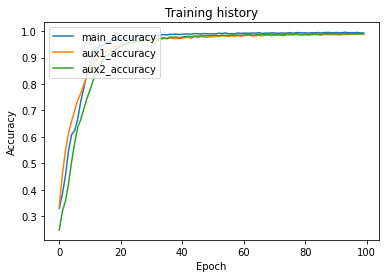

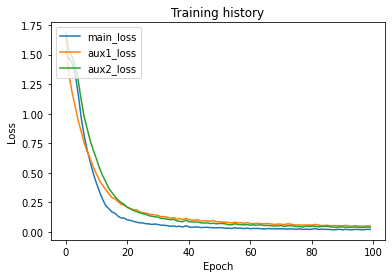

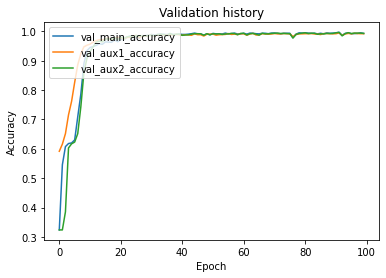

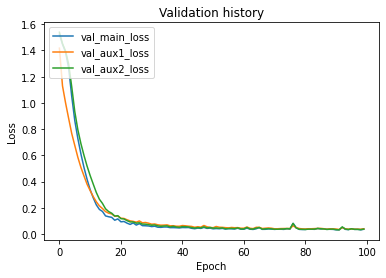

In [ ]:
show_train_history(history_all, 'Epoch', 'Accuracy', ('main_accuracy', 'aux1_accuracy', 'aux2_accuracy'), 'Training history')
show_train_history(history_all, 'Epoch', 'Loss', ('main_loss', 'aux1_loss', 'aux2_loss'), 'Training history')
show_train_history(history_all, 'Epoch', 'Accuracy', ('val_main_accuracy', 'val_aux1_accuracy', 'val_aux2_accuracy'), 'Validation history')
show_train_history(history_all, 'Epoch', 'Loss', ('val_main_loss', 'val_aux1_loss', 'val_aux2_loss'), 'Validation history')

In [ ]:
model = keras.models.load_model('GoogLeNet.h5')

In [ ]:
Y_pred = model.predict(val_generator)

In [ ]:
y_pred = np.argmax(Y_pred[0], axis=1)

In [ ]:
print('Confusion Matrix')
print(confusion_matrix(val_generator.classes, y_pred))
print('Classification Report')
CLASS_NAMES= ['basophil', 'eosinophil', 'lymphocyte', 'monocyte', 'neutrophil']
print(classification_report(val_generator.classes, y_pred, target_names=CLASS_NAMES))

In [ ]:
from google.colab import files
files.download('GoogLeNet.h5')